# PyCIEMSS optimize interface with different intervention types

### Load dependencies and interfaces

In [1]:
import os
import torch
import pyro
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
import time

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [30]:
start_time = 0.0
end_time_SIR = 40.0
end_time_SEIRHD = 60.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 1000
num_samples_ouu = 10 if smoke_test else 1000 # controls accuracy of risk estimation in each optimization iteration
maxiter = 0 if smoke_test else 2    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 1 if smoke_test else 20  # maximum number of function evaluations in each instance of local convex optimization

### Define QoI function

In [4]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    ndays = 1 leads to using the value at the end of the simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

### Baseline samples before optimization from model 1

Time taken:  3.2530856132507324
Risk associated with QoI: [488.838154296875]


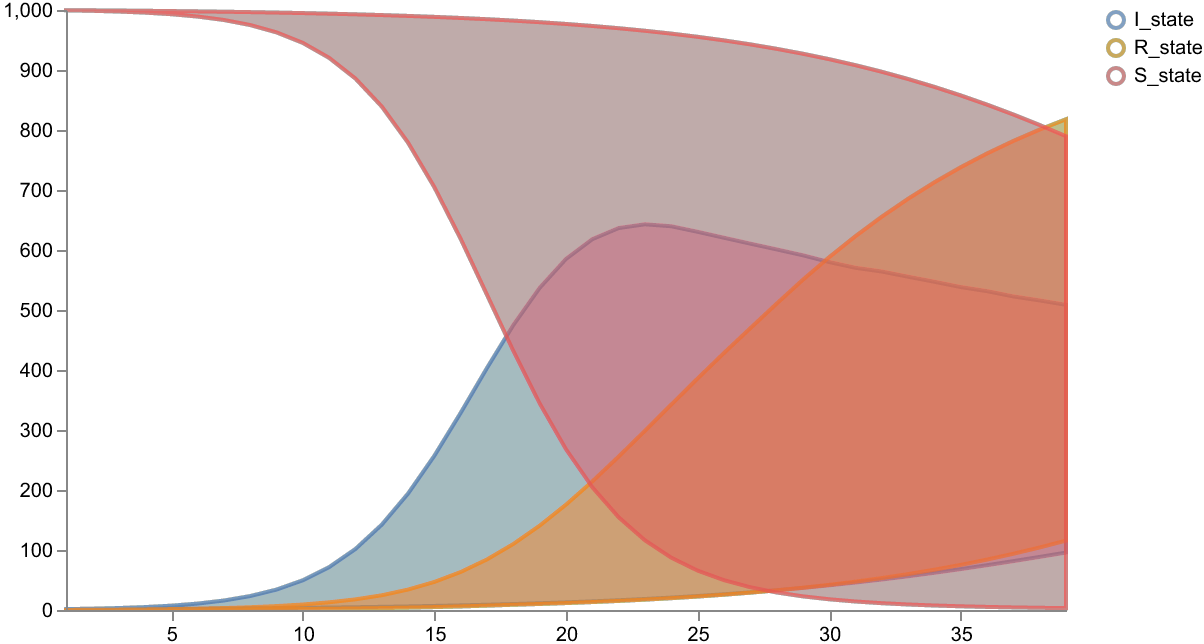

In [31]:
start_t = time.time()
sample_results1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results1["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Baseline samples before optimization from model 2

Time taken:  9.450354814529419
Risk associated with QoI: [4748819.739999998]


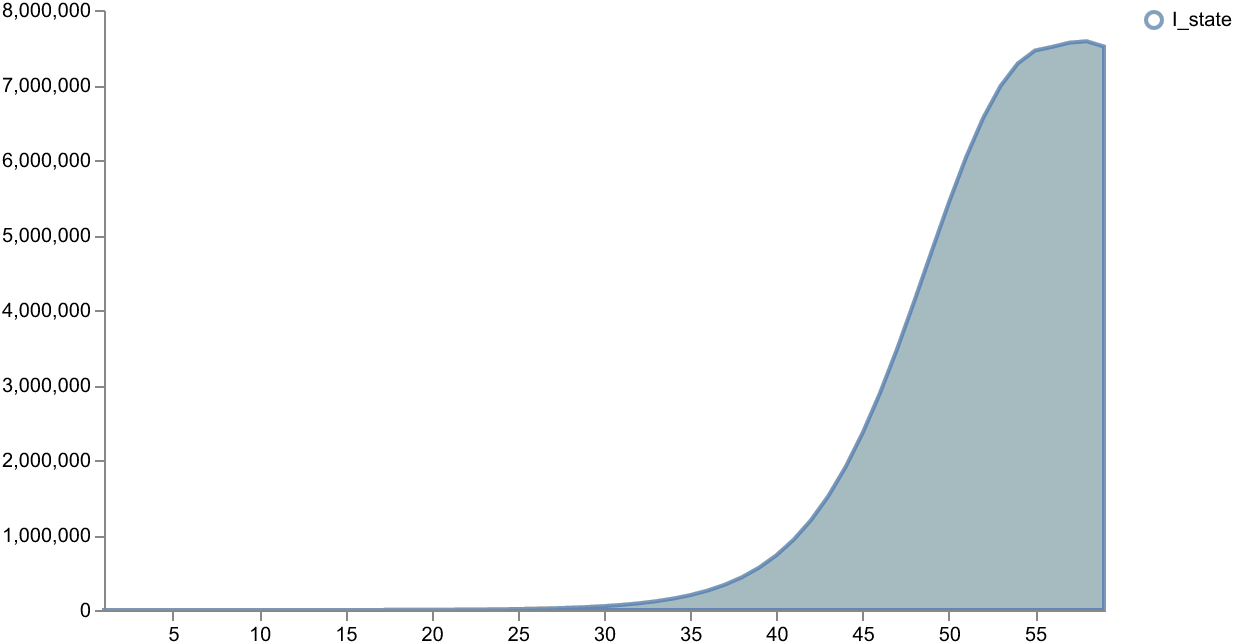

In [32]:
start_t = time.time()
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    num_samples,
    start_time=start_time,
    # solver_method="dopri5",
    solver_method="rk4",
    solver_options={"step_size": 1.}
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results2["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with single intervention
### Optimizing a single parameter value (SIR)
Minimum change in the intervention parameter from the current value to get infections below 300 individuals at 40 days for SIR model

In [7]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

  0%|          | 0/60 [00:00<?, ?it/s]

[0.15]
Risk:  53.392703704833984
[0.15]


  2%|▏         | 1/60 [00:05<05:13,  5.32s/it]

Risk:  53.392703704833984
[0.19]


  3%|▎         | 2/60 [00:07<03:12,  3.31s/it]

Risk:  180.94763305664063
[0.19597464]


  5%|▌         | 3/60 [00:10<03:07,  3.29s/it]

Risk:  209.86927246093748
[0.19393584]


  7%|▋         | 4/60 [00:12<02:43,  2.93s/it]

Risk:  199.76724304199217
[0.19424834]


  8%|▊         | 5/60 [00:15<02:41,  2.94s/it]

Risk:  201.30099182128905
[0.19398327]


 10%|█         | 6/60 [00:18<02:29,  2.77s/it]

Risk:  199.9996875
[0.19399303]


 12%|█▏        | 7/60 [00:21<02:34,  2.92s/it]

Risk:  200.04751586914062
[0.19425726]
Risk:  201.34479431152343
[0.19425726]


 13%|█▎        | 8/60 [00:26<03:02,  3.51s/it]

Risk:  201.34479431152343
[0.23425726]


 15%|█▌        | 9/60 [00:28<02:33,  3.02s/it]

Risk:  405.2231964111328
[0.18925726]


 17%|█▋        | 10/60 [00:30<02:20,  2.80s/it]

Risk:  177.5058428955078
[0.19488226]


 18%|█▊        | 11/60 [00:32<02:11,  2.69s/it]

Risk:  204.42876525878904
[0.19398472]


 20%|██        | 12/60 [00:35<02:12,  2.76s/it]

Risk:  200.00677490234375
[0.19394566]


 22%|██▏       | 13/60 [00:38<02:02,  2.61s/it]

Risk:  199.81536193847654
[0.19398972]


 23%|██▎       | 14/60 [00:40<01:51,  2.41s/it]

Risk:  200.03131591796875
[0.28568986]
Risk:  504.4845275878906
[0.28568986]


 25%|██▌       | 15/60 [00:44<02:15,  3.01s/it]

Risk:  504.4845275878906
[0.32568986]


 27%|██▋       | 16/60 [00:46<02:03,  2.80s/it]

Risk:  475.1239855957031
[0.36568986]


 28%|██▊       | 17/60 [00:48<01:51,  2.59s/it]

Risk:  427.3744842529297
[0.40568986]


 30%|███       | 18/60 [00:51<01:44,  2.48s/it]

Risk:  384.4240167236328
[0.38568986]


 32%|███▏      | 19/60 [00:53<01:37,  2.37s/it]

Risk:  404.86385131835937
[0.39568986]


 33%|███▎      | 20/60 [00:55<01:32,  2.31s/it]

Risk:  394.37196960449216
[0.40568986]


 35%|███▌      | 21/60 [00:57<01:26,  2.22s/it]

Risk:  384.4240167236328
[0.41568986]


 37%|███▋      | 22/60 [00:59<01:25,  2.26s/it]

Risk:  375.0219189453125
[0.42568986]


 38%|███▊      | 23/60 [01:02<01:27,  2.37s/it]

Risk:  366.15611267089844
[0.43568986]


 40%|████      | 24/60 [01:05<01:31,  2.55s/it]

Risk:  357.80692016601563
[0.44568986]


 42%|████▏     | 25/60 [01:08<01:30,  2.58s/it]

Risk:  349.95359985351564
[0.45568986]


 43%|████▎     | 26/60 [01:10<01:26,  2.54s/it]

Risk:  342.56408142089845
[0.46568986]


 45%|████▌     | 27/60 [01:13<01:29,  2.72s/it]

Risk:  335.6105084228516
[0.47568986]


 47%|████▋     | 28/60 [01:16<01:24,  2.63s/it]

Risk:  329.0650872802734
[0.48568986]


 48%|████▊     | 29/60 [01:18<01:19,  2.57s/it]

Risk:  322.9006884765625
[0.49568986]


 50%|█████     | 30/60 [01:21<01:18,  2.61s/it]

Risk:  317.0912432861328
[0.50568986]
[0.50068986]
[0.49318986]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 55%|█████▌    | 33/60 [01:24<00:45,  1.69s/it]

Risk:  318.5116961669922
[0.49693986]


 58%|█████▊    | 35/60 [01:26<01:02,  2.48s/it]

Risk:  316.3887744140625
Optimal policy: tensor([0.1940], dtype=torch.float64)
{'policy': tensor([0.1940], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.15601673345676997
                          x: [ 1.940e-01]
                        nit: 2
      minimization_failures: 2
                       nfev: 34
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.15601673345676997
                                   x: [ 1.940e-01]
                                nfev: 7
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Intervention:  {1.0: {'p_cbeta': tensor(0.1940)}}


Risk associated with QoI: [197.49244567871094]


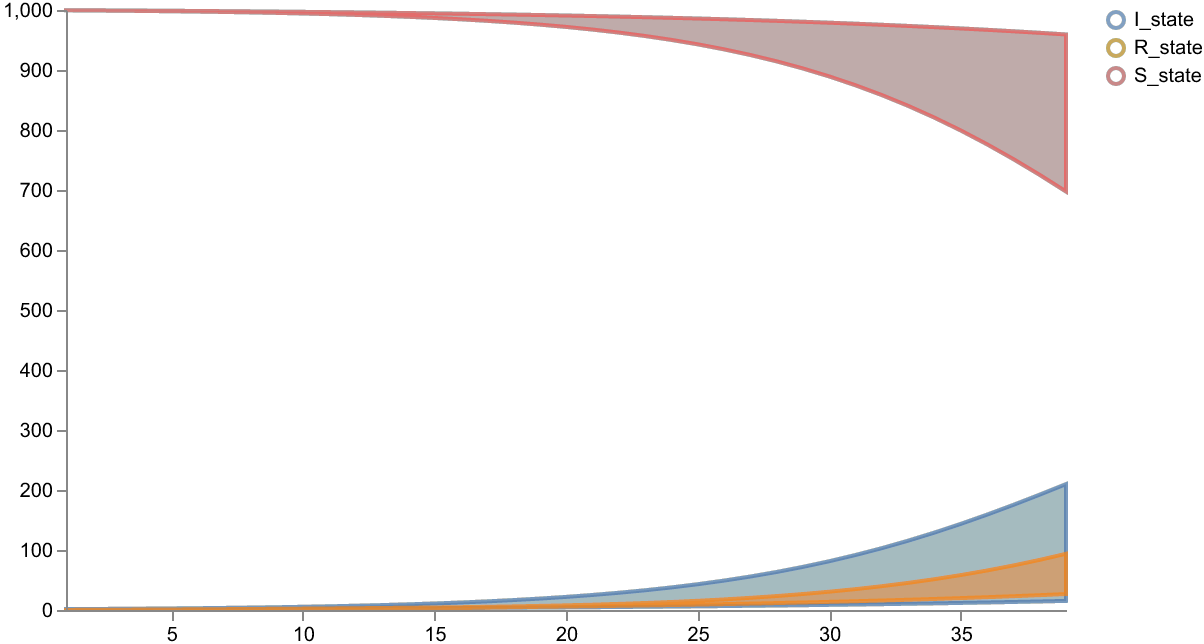

In [8]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))
result1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
# display(result1["data"])
print("Risk associated with QoI:", result1["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)


### Optimizing the start time for a single intervention (SIR)
Maximum delay in the intervention to get infections below 300 individuals at 40 days for SIR model

In [9]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 5.
bounds_interventions = [[1.], [39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

  0%|          | 0/60 [00:00<?, ?it/s]

[5.]
Risk:  126.89316650390624
[5.]


  2%|▏         | 1/60 [00:04<04:37,  4.71s/it]

Risk:  126.89316650390624
[8.8]


  3%|▎         | 2/60 [00:07<03:17,  3.41s/it]

Risk:  230.5316015625
[7.68053032]


  5%|▌         | 3/60 [00:10<03:02,  3.21s/it]

Risk:  199.56992553710936
[7.91803032]


  7%|▋         | 4/60 [00:12<02:41,  2.88s/it]

Risk:  206.26942260742186
[7.71021782]


  8%|▊         | 5/60 [00:14<02:25,  2.65s/it]

Risk:  200.40821044921873
[7.69576122]


 10%|█         | 6/60 [00:16<02:12,  2.46s/it]

Risk:  200.00000976562498
[7.69390575]


 12%|█▏        | 7/60 [00:19<02:11,  2.48s/it]

Risk:  199.947626953125
[7.69599315]


 13%|█▎        | 8/60 [00:21<02:07,  2.45s/it]

Risk:  200.00657287597653
[7.69573223]


 15%|█▌        | 9/60 [00:24<02:02,  2.40s/it]

Risk:  199.9991857910156
[7.69576622]


 17%|█▋        | 10/60 [00:26<02:04,  2.49s/it]

Risk:  200.00016784667966
[10.73352897]
Risk:  276.83643127441405
[10.73352897]


 18%|█▊        | 11/60 [00:31<02:40,  3.28s/it]

Risk:  276.83643127441405
[14.53352897]


 20%|██        | 12/60 [00:34<02:22,  2.97s/it]

Risk:  325.58774536132813
[6.93352897]


 22%|██▏       | 13/60 [00:36<02:15,  2.87s/it]

Risk:  178.50229248046872
[7.76428103]


 23%|██▎       | 14/60 [00:39<02:03,  2.69s/it]

Risk:  201.93427246093748
[7.88303103]


 25%|██▌       | 15/60 [00:41<01:55,  2.56s/it]

Risk:  205.28330139160155
[7.69569552]


 27%|██▋       | 16/60 [00:44<01:54,  2.61s/it]

Risk:  199.99815979003904
[7.71053927]


 28%|██▊       | 17/60 [00:46<01:54,  2.65s/it]

Risk:  200.41728759765624
[7.69755099]


 30%|███       | 18/60 [00:48<01:44,  2.50s/it]

Risk:  200.0505529785156
[7.69592746]


 32%|███▏      | 19/60 [00:51<01:37,  2.38s/it]

Risk:  200.00473022460935
[7.69576048]


 33%|███▎      | 20/60 [00:53<01:40,  2.50s/it]

Risk:  199.99997558593748
[7.69577498]


 35%|███▌      | 21/60 [00:56<01:41,  2.59s/it]

Risk:  200.00041076660153
[1.79914424]
Risk:  64.01446151733398
[1.79914424]


 37%|███▋      | 22/60 [01:01<02:00,  3.18s/it]

Risk:  64.01446151733398
[5.59914424]


 38%|███▊      | 23/60 [01:03<01:47,  2.89s/it]

Risk:  142.13589935302733
[8.41378243]


 40%|████      | 24/60 [01:05<01:38,  2.73s/it]

Risk:  220.0345648193359
[7.68989261]


 42%|████▏     | 25/60 [01:08<01:31,  2.62s/it]

Risk:  199.83431091308591
[7.80864261]


 43%|████▎     | 26/60 [01:10<01:22,  2.43s/it]

Risk:  203.18588562011718
[7.70473636]


 45%|████▌     | 27/60 [01:12<01:20,  2.44s/it]

Risk:  200.25345703124998
[7.69576036]


 47%|████▋     | 28/60 [01:15<01:19,  2.50s/it]

Risk:  199.99997558593748
[7.6966881]


 48%|████▊     | 29/60 [01:17<01:18,  2.52s/it]

Risk:  200.02619201660156
[7.69587633]


 50%|█████     | 30/60 [01:19<01:12,  2.41s/it]

Risk:  200.00326354980467
[7.69577486]


 52%|█████▏    | 31/60 [01:22<01:17,  2.66s/it]

Risk:  200.00041076660153
Optimal policy: tensor([7.6958], dtype=torch.float64)
{'policy': tensor([7.6958], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -7.69576122033028
                          x: [ 7.696e+00]
                        nit: 2
      minimization_failures: 0
                       nfev: 31
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -7.69576122033028
                                   x: [ 7.696e+00]
                                nfev: 10
                               maxcv: 9.765624980673238e-06}
Intervention:  {7.6958: {'p_cbeta': tensor(0.1500)}}


Risk associated with QoI: [147.76781677246092]


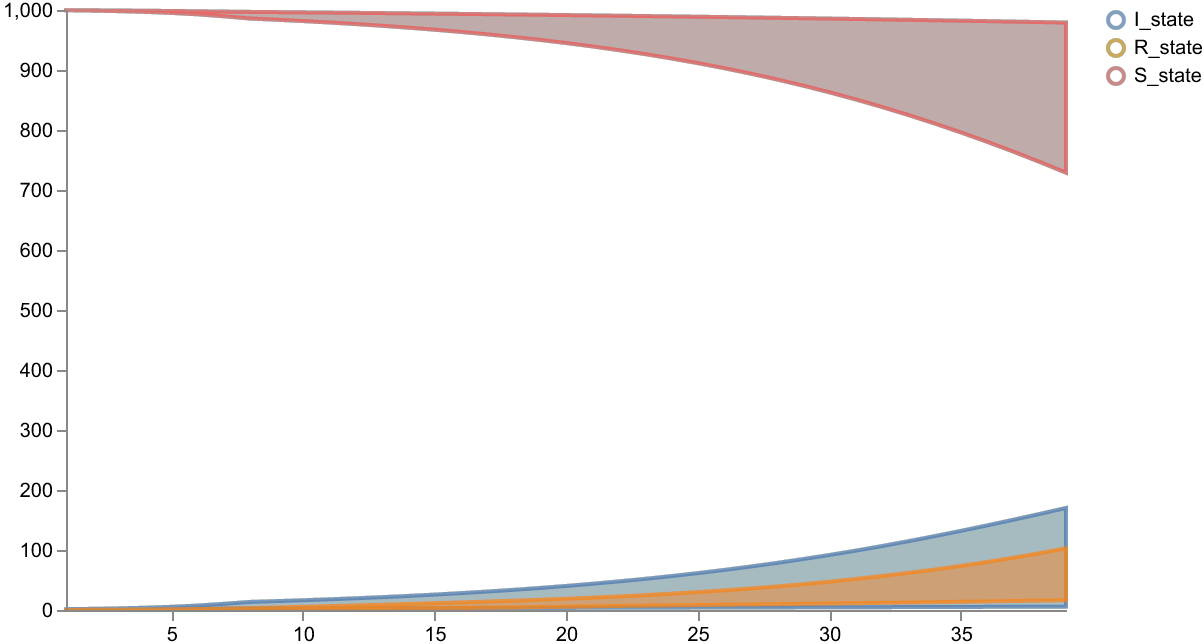

In [10]:
result2 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
    solver_options={"step_size": 1.},
)
# display(result2["data"])
# Check risk estimate used in constraints
print("Risk associated with QoI:", result2["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple interventions
### Optimizing multiple intervention values (SEIRHD)
Minimum change in two intervention parameters from their current values to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

In [33]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.2, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass ina list of lambda x: torch.tensor(x) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 3e4
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.sum(np.abs(param_current - x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f"Optimal policy:", opt_result3["policy"])
print(opt_result3)
print("Intervention: ", static_parameter_interventions(opt_result3["policy"]))

  0%|          | 0/60 [00:00<?, ?it/s]

[0.2 0.4]
Risk:  73081.50578124996
[0.2 0.4]


  2%|▏         | 1/60 [00:12<12:11, 12.40s/it]

Risk:  73081.50578124996
[0.25656854 0.4       ]


  3%|▎         | 2/60 [00:17<08:06,  8.39s/it]

Risk:  73081.50578124996
[0.25656854 0.45656854]


  5%|▌         | 3/60 [00:24<07:13,  7.61s/it]

Risk:  26481.18796874999
[0.31297558 0.45229703]


  7%|▋         | 4/60 [00:31<06:38,  7.12s/it]

Risk:  28534.347890624987
[0.369432   0.44873713]


  8%|▊         | 5/60 [00:37<06:19,  6.90s/it]

Risk:  30374.46042968749
[0.42599345 0.44784134]


 10%|█         | 6/60 [00:43<06:01,  6.69s/it]

Risk:  30857.032851562486
[0.37121195 0.47696534]


 12%|█▏        | 7/60 [00:50<05:48,  6.57s/it]

Risk:  18627.415703124992
[0.42597322 0.45049506]


 13%|█▎        | 8/60 [00:56<05:39,  6.53s/it]

Risk:  29450.547929687487
[0.39768507 0.45006531]


 15%|█▌        | 9/60 [01:02<05:27,  6.41s/it]

Risk:  29673.627617187485
[0.35533108 0.44981599]


 17%|█▋        | 10/60 [01:08<05:13,  6.26s/it]

Risk:  29803.870546874987
[0.34120946 0.44905438]


 18%|█▊        | 11/60 [01:15<05:18,  6.51s/it]

Risk:  30205.48257812499
[0.35479165 0.44276553]


 20%|██        | 12/60 [01:22<05:21,  6.69s/it]

Risk:  33749.251640624985
[0.34236653 0.44951952]


 22%|██▏       | 13/60 [01:28<05:06,  6.51s/it]

Risk:  29959.535273437486
[0.36239394 0.44947552]


 23%|██▎       | 14/60 [01:35<05:01,  6.56s/it]

Risk:  29982.701445312487
[0.35181195 0.4494758 ]


 25%|██▌       | 15/60 [01:42<05:00,  6.68s/it]

Risk:  29982.555703124985
[0.3482768  0.44942352]


 27%|██▋       | 16/60 [01:49<04:54,  6.69s/it]

Risk:  30010.121640624988
[0.34650911 0.44943998]


 28%|██▊       | 17/60 [01:56<04:57,  6.91s/it]

Risk:  30001.44480468749
[0.34828503 0.45030736]


 30%|███       | 18/60 [02:03<04:48,  6.87s/it]

Risk:  29547.75406249999
[0.35004446 0.44944299]


 32%|███▏      | 19/60 [02:10<04:47,  7.01s/it]

Risk:  29999.85824218749
[0.35181223 0.44944257]


 33%|███▎      | 20/60 [02:19<04:58,  7.46s/it]

Risk:  30000.076796874986
[0.23512897 0.32329753]
Risk:  309351.1281249999
[0.23512897 0.32329753]


 37%|███▋      | 22/60 [02:32<04:29,  7.10s/it]

Risk:  309351.1281249999
[0.29169751 0.32329753]


 38%|███▊      | 23/60 [02:39<04:22,  7.10s/it]

Risk:  309351.1281249999
[0.29169751 0.37986608]


 40%|████      | 24/60 [02:46<04:13,  7.03s/it]

Risk:  106172.21406249996
[0.34414019 0.40107374]


 42%|████▏     | 25/60 [02:53<04:01,  6.91s/it]

Risk:  71651.56781249997
[0.39581187 0.4240963 ]


 43%|████▎     | 26/60 [03:01<04:03,  7.16s/it]

Risk:  47108.92304687498
[0.36700298 0.41772586]


 45%|████▌     | 27/60 [03:06<03:40,  6.68s/it]

Risk:  52859.68234374998
[0.33581413 0.41250514]


#### Sample using optimal policy as intervention

Risk associated with QoI: [2580.4086474609367]


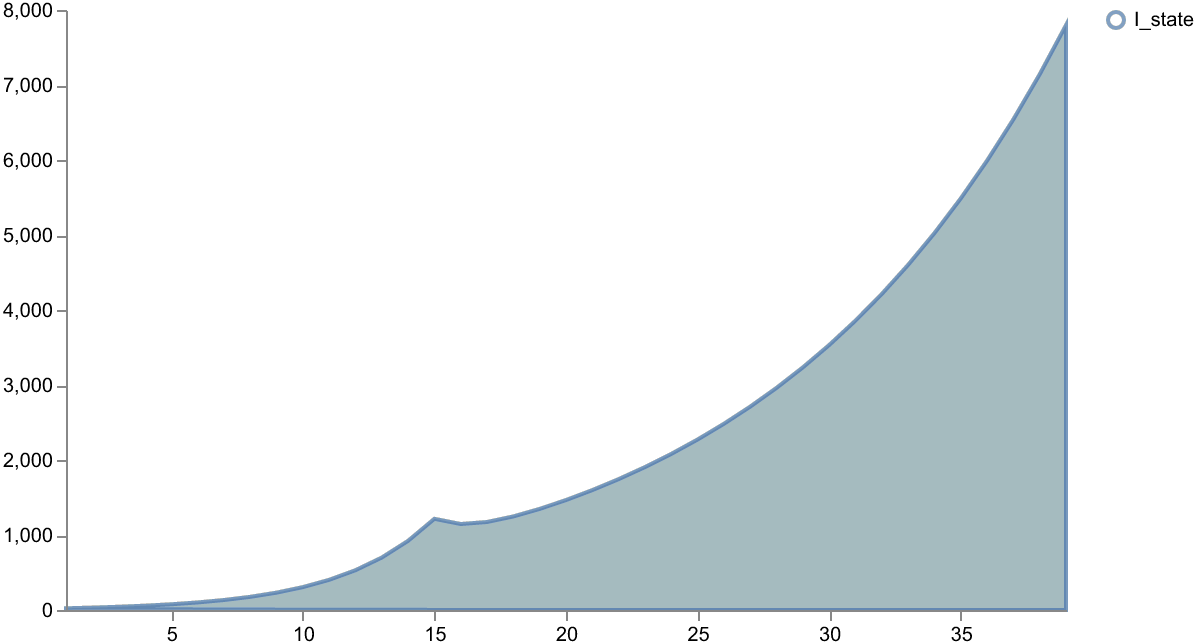

In [12]:
with pyro.poutine.seed(rng_seed=0):
    result3 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result3["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Optimizing for start times of multiple interventions (SEIRHD)
Maximum delay in starting two interventions to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c to be 0.15
* Intervene on gamma to be 0.35

In [13]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["beta_c", "gamma"]
initial_guess_interventions = [torch.tensor(10.), torch.tensor(10.)]
bounds_interventions = [[10., 10.], [30., 30.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15, 0.4])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 800.
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result4 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result4["policy"])
print(opt_result4)
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))

  0%|          | 0/60 [00:00<?, ?it/s]

[10. 10.]
Risk:  4058.2595410156237
[10. 10.]


  2%|▏         | 1/60 [00:09<09:37,  9.79s/it]

Risk:  4058.2595410156237
[12.82842712 10.        ]


  3%|▎         | 2/60 [00:15<06:52,  7.11s/it]

Risk:  4062.4236230468737
[12.82842712 12.82842712]


  5%|▌         | 3/60 [00:19<05:44,  6.04s/it]

Risk:  5573.810058593748
[12.82063444  7.17158361]
[12.82453078  8.58579181]
[12.28572956  8.12786905]
[12.98023908  8.26074695]
[11.78572956  7.62786905]
[11.28572956  7.12786905]
[10.78572956  6.62786905]
[10.28572956  6.12786905]
[9.78572956 5.62786905]
[9.28572956 5.12786905]
[8.78572956 4.62786905]
[8.28572956 4.12786905]
[7.78572956 3.62786905]
[7.28572956 3.12786905]
[6.78572956 2.62786905]
[6.28572956 2.12786905]
[5.78572956 1.62786905]
[10. 10.]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: Use

Risk:  4058.2595410156237
[10. 10.]


 37%|███▋      | 22/60 [00:28<00:32,  1.16it/s]

Risk:  4058.2595410156237
[12.82842712 10.        ]


 38%|███▊      | 23/60 [00:33<00:42,  1.15s/it]

Risk:  4062.4236230468737
[12.82842712 12.82842712]


 40%|████      | 24/60 [00:39<00:55,  1.53s/it]

Risk:  5573.810058593748
[12.82063444  7.17158361]
[12.82453078  8.58579181]
[12.28572956  8.12786905]
[12.98023908  8.26074695]
[11.78572956  7.62786905]
[11.28572956  7.12786905]
[10.78572956  6.62786905]
[10.28572956  6.12786905]
[9.78572956 5.62786905]
[9.28572956 5.12786905]
[8.78572956 4.62786905]
[8.28572956 4.12786905]
[7.78572956 3.62786905]
[7.28572956 3.12786905]
[6.78572956 2.62786905]
[6.28572956 2.12786905]
[5.78572956 1.62786905]
[11.98478291 10.        ]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: Use

Risk:  4058.7048535156237
[11.98478291 10.        ]


 72%|███████▏  | 43/60 [00:48<00:13,  1.24it/s]

Risk:  4058.7048535156237
[14.81321003 10.        ]


 73%|███████▎  | 44/60 [00:52<00:15,  1.03it/s]

Risk:  4062.704052734374
[14.81321003 12.82842712]


 75%|███████▌  | 45/60 [00:56<00:17,  1.18s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Docume

Risk:  5574.188828124998
[14.80572639  7.17158278]
[14.80946821  8.58579139]
[14.27063805  8.1279027 ]
[14.96515848  8.26072352]
[13.77063805  7.6279027 ]
[13.27063805  7.1279027 ]
[12.77063805  6.6279027 ]
[12.27063805  6.1279027 ]
[11.77063805  5.6279027 ]
[11.27063805  5.1279027 ]
[10.77063805  4.6279027 ]
[10.27063805  4.1279027 ]
[9.77063805 3.6279027 ]
[9.27063805 3.1279027 ]
[8.77063805 2.6279027 ]
[8.27063805 2.1279027 ]
[7.77063805 1.6279027 ]
Optimal policy: tensor([5.7858, 1.6279], dtype=torch.float64)
{'policy': tensor([5.7858, 1.6279], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 29.654394468613624
                          x: [ 5.786e+00  1.628e+00]
                        nit: 2
      minimization_failures: 3
                       nfev: 60
 lowest_optimization_result: message: Did not converge to a solution satisfying

In [14]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="rk4",
        # solver_method="euler",
        solver_options={"step_size":1.},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

KeyboardInterrupt: 

Time taken:  8.754577875137329


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.000401,35.022633,0.347615,15.055376,2.281618,19339988.0,15.055376,35.022633,0.347615,0.000401
1,1,0,2.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.002079,33.224503,0.807116,19.599751,5.804692,19339978.0,19.599751,33.224503,0.807116,0.002079
2,2,0,3.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.005284,33.259682,1.304054,22.958223,10.228070,19339968.0,22.958223,33.259682,1.304054,0.005284
3,3,0,4.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.010082,34.387726,1.803558,25.722313,15.370486,19339958.0,25.722313,34.387726,1.803558,0.010082
4,4,0,5.0,0.150000,0.395880,0.350000,0.141744,0.015949,8.265465,0.016462,36.204086,2.291641,28.224468,21.141350,19339948.0,28.224468,36.204086,2.291641,0.016462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.208786,1096.966431,312.458801,1281.773193,18390.800781,19318934.0,1281.773193,1096.966431,312.458801,19.208786
9896,95,99,96.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.917933,926.298035,295.937378,1113.679565,18831.251953,19318848.0,1113.679565,926.298035,295.937378,19.917933
9897,96,99,97.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,20.586340,783.916748,276.983704,962.387268,19217.660156,19318774.0,962.387268,783.916748,276.983704,20.586340
9898,97,99,98.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,21.209364,664.521973,256.629974,828.412659,19554.992188,19318710.0,828.412659,664.521973,256.629974,21.209364


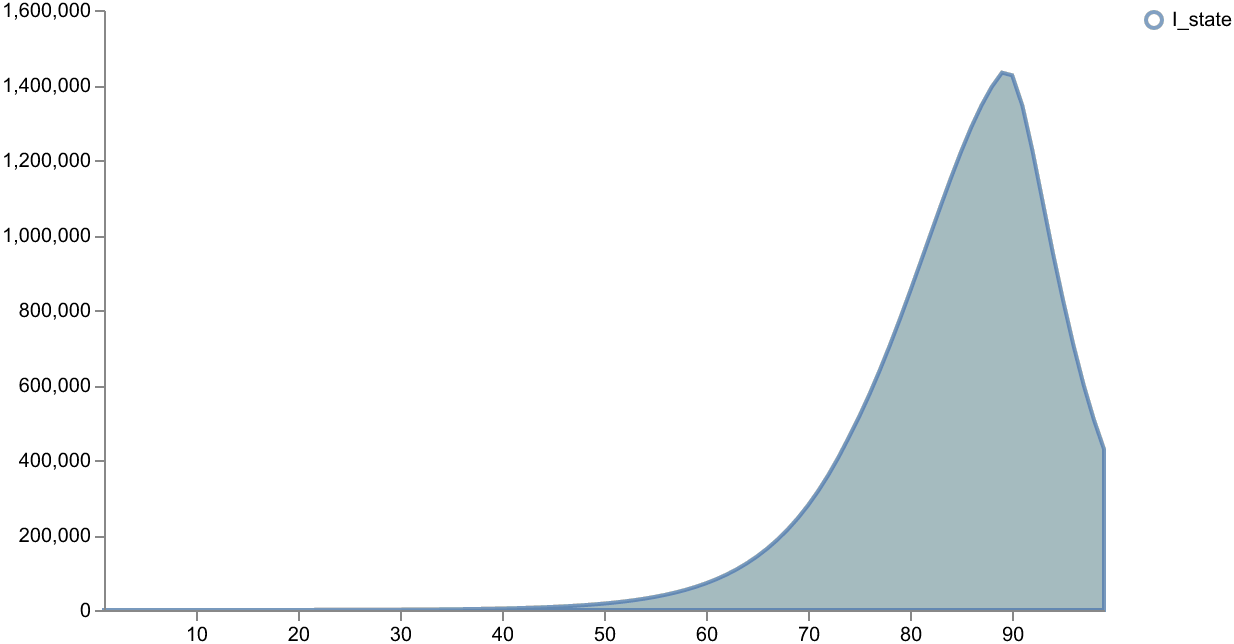

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="euler",
        solver_options={"step_size": 0.1},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

Time taken:  16.12155294418335


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.006537,35.195354,0.838740,15.583101,4.126128,19339988.0,15.583101,35.195354,0.838740,0.006537
1,1,0,2.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.027022,32.389149,1.720320,17.855694,9.369328,19339978.0,17.855694,32.389149,1.720320,0.027022
2,2,0,3.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.061201,30.680210,2.541366,18.979063,15.257811,19339972.0,18.979063,30.680210,2.541366,0.061201
3,3,0,4.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.107720,29.574734,3.260566,19.474323,21.519539,19339978.0,19.474323,29.574734,3.260566,0.107720
4,4,0,5.0,0.150000,0.333112,0.350000,0.185165,0.079923,11.210128,0.164840,28.802074,3.867827,19.627031,27.994497,19339960.0,19.627031,28.802074,3.867827,0.164840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.584401,18.269659,2.709901,22.405989,894.369629,19339110.0,22.405989,18.269659,2.709901,0.584401
9896,95,99,96.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.592176,15.260543,2.527707,19.297033,901.831299,19339110.0,19.297033,15.260543,2.527707,0.592176
9897,96,99,97.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.599391,12.771304,2.334918,16.531406,908.276794,19339110.0,16.531406,12.771304,2.334918,0.599391
9898,97,99,98.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.606029,10.704046,2.138563,14.106043,913.817993,19339110.0,14.106043,10.704046,2.138563,0.606029


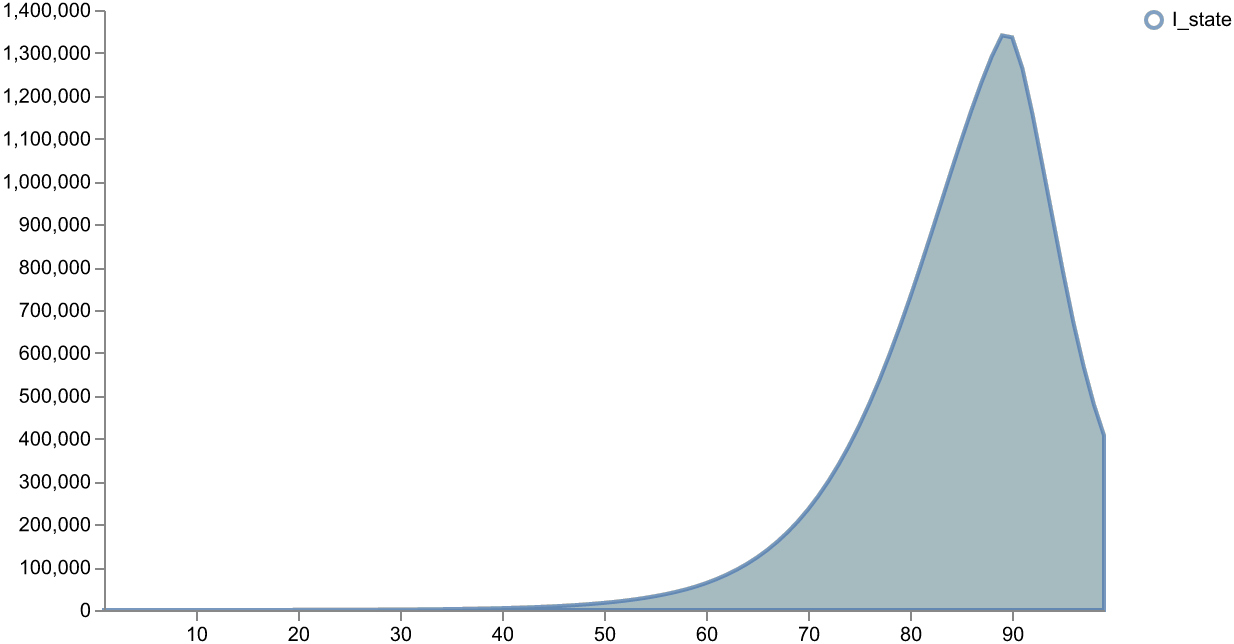

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="dopri5",
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)